### Student Information
Name: Sarunyu Srisonthong

Student ID: 110062428

GitHub ID: SarunWu

Kaggle name: Daxiiez

Kaggle private scoreboard snapshot:

![score_board](./img/best.png)


# Kaggle competition
## Outline
1. Preprocessing
    - f
2. Exploratory Data Analysis (EDA)
    - Find outliers
    - 
3. Feature engineering
4. Training Model 
5. Model Selection


In [ ]:
# Import libraries
import pandas as pd
import helpers.data_mining_helpers as dmh

### 1: Import collected tweets dataset

In [ ]:
# data identification test & train data
data_identification = pd.read_csv("data/emotion_tweet/data_identification.csv")
emotion = pd.read_csv("data/emotion_tweet/emotion.csv")

Because the training data is in json structure, we need to normalize (split it into seperate columns)

In [ ]:
import json
tweets_DM = pd.read_json(r'data/emotion_tweet/tweets_DM.json', lines=True, orient='columns')
# normalize json data
data = tweets_DM['_source'].tolist()
df = pd.DataFrame.from_dict(pd.json_normalize(data), orient='columns')
tweets_DM = pd.concat([tweets_DM, df], axis=1)

To process efficiently, we compress size for saving memory space

In [ ]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% Compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
tweets_DM = downcast(tweets_DM)
data_identification = downcast(data_identification)
emotion = downcast(emotion)

In [ ]:
data_identification.head()

In [ ]:
# 1. rename column
tweets_DM= tweets_DM.rename(columns={'tweet.tweet_id': 'id', 'tweet.text': 'text','tweet.hashtags':'hashtags'})

# 2. drop unused columns
tweets_DM=tweets_DM.drop(['_source','_index','_type','_score', '_crawldate','hashtags'], axis=1)
data_identification= data_identification.rename(columns={'tweet_id': 'id'})
emotion= emotion.rename(columns={'tweet_id': 'id'})

# 3. put it in new dataframe
tweet_df = tweets_DM

In [ ]:
# Separating train and test set data

# Train dataset
train_data = data_identification[data_identification['identification'] == 'train']
train_data = pd.merge(train_data, tweet_df,  how='left',
                     left_on=['id'], right_on=['id'])
train_data = pd.merge(train_data, emotion,  how='left',
                     left_on=['id'], right_on=['id'])

# Test dataset
test_data = data_identification[data_identification['identification'] == 'test']
test_data = pd.merge(test_data, tweet_df,  how='left',
                    left_on=['id'], right_on=['id'])

train_data.shape, test_data.shape

In [ ]:
# shuffle dataset
train_data = train_data.sample(frac=1)
test_data = test_data.sample(frac=1)

In [ ]:
# save data files
train_data.to_pickle("uncleaned_train_data.pkl")
test_data.to_pickle("uncleaned_test_data.pkl")

In [25]:
# Continue working from saved files
import pandas as pd

train_data = pd.read_pickle("uncleaned_train_data.pkl")
test_data = pd.read_pickle("uncleaned_test_data.pkl")

In [26]:
# Check if there is missing values in both train and test dataset

import helpers.data_mining_helpers as dmh
train_data.isnull().apply(lambda x: dmh.check_missing_values(x))

,id,identification,text,emotion
0,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:
1,0,0,0,0


In [27]:
test_data.isnull().apply(lambda x: dmh.check_missing_values(x))

,id,identification,text
0,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:
1,0,0,0


In [28]:
# Count sentence length and words

train_data['length'] = [len(t) for t in train_data['text']]
train_data['count'] = train_data['text'].apply(lambda x: len(str(x).split(" ")))

test_data['length'] = [len(t) for t in test_data['text']]
test_data['count'] = test_data['text'].apply(lambda x: len(str(x).split(" ")))

test_data.head()

,id,identification,text,length,count
226319,0x350ee7,test,@fifty_two___ @loubielou32 It wasn’t literal -...,134,21
94959,0x1cc41b,test,My god it's so annoying when guys call you bab...,138,25
310262,0x2dde0d,test,Color me surprised .. The radio is Rocking Out...,94,16
23608,0x343d18,test,More thunderstorms today... UGH! #rainraingoaw...,72,8
297538,0x285e33,test,So happy to have a bf that will take good pict...,78,17


In [29]:
from helpers.emotion_dict import demoticon, replace_con_slang
from helpers.text_analysis import cleaning_text


In [30]:
%%time
# preprocessing 1
# convert emoticon like (':)') into word (smiley)
train_data['cleantext'] = train_data['text'].apply(lambda x: demoticon(x))
test_data['cleantext'] = test_data['text'].apply(lambda x: demoticon(x))
train_data.head()

CPU times: user 5.47 s, sys: 71.9 ms, total: 5.55 s
Wall time: 5.58 s


,id,identification,text,emotion,length,count,cleantext
583292,0x2b6005,train,<LH> bikin rv x bts kuy -lead rv,anticipation,32,8,<LH> bikin rv x bts kuy -lead rv
1152023,0x35a043,train,Wtf I’m so emotional Ed’s MV is so <LH>,joy,39,9,Wtf I'm so emotional Ed's MV is so <LH>
1428044,0x2e0dbd,train,Who is watching #IUFb v. Ohio State? Let's kee...,trust,87,15,Who is watching #IUFb v. Ohio State? Let's kee...
484526,0x20af4e,train,"Count your blessings, not your problems... 💜 <LH>",joy,49,8,"Count your blessings, not your problems... 💜 <LH>"
880761,0x20b6ff,train,@JackPosobiec @paphotog more <LH> eyes,surprise,38,5,@JackPosobiec @paphotog more <LH> eyes


In [31]:
%%time
# preprocessing 2
# remove noisy words
# 1. urls
# 2. whitespace
# 3. mentions
# 4. hashtags
# 5. html tags
# 6. multiple letters
# 7. To lowercase letters
# 8. symbols

train_data['cleantext'] = train_data['cleantext'].apply(lambda x: cleaning_text(x))
test_data['cleantext'] = test_data['cleantext'].apply(lambda x: cleaning_text(x))
train_data.head()

CPU times: user 31.8 s, sys: 137 ms, total: 31.9 s
Wall time: 32.5 s


,id,identification,text,emotion,length,count,cleantext
583292,0x2b6005,train,<LH> bikin rv x bts kuy -lead rv,anticipation,32,8,bikin rv x bts kuy lead rv
1152023,0x35a043,train,Wtf I’m so emotional Ed’s MV is so <LH>,joy,39,9,wtf i'm so emotional ed's mv is so
1428044,0x2e0dbd,train,Who is watching #IUFb v. Ohio State? Let's kee...,trust,87,15,who is watching iufb v ohio state let's keep t...
484526,0x20af4e,train,"Count your blessings, not your problems... 💜 <LH>",joy,49,8,count your blessings not your problems 💜
880761,0x20b6ff,train,@JackPosobiec @paphotog more <LH> eyes,surprise,38,5,more eyes


In [32]:
%%time
# preprocessing 3
# convert emoticon like (':)') into word (smiley)
train_data['cleantext'] = train_data['cleantext'].apply(lambda x: replace_con_slang(x))
test_data['cleantext'] = test_data['cleantext'].apply(lambda x: replace_con_slang(x))
train_data.head()

CPU times: user 16.5 s, sys: 65.3 ms, total: 16.6 s
Wall time: 16.6 s


,id,identification,text,emotion,length,count,cleantext
583292,0x2b6005,train,<LH> bikin rv x bts kuy -lead rv,anticipation,32,8,bikin rv kiss bts kuy lead rv
1152023,0x35a043,train,Wtf I’m so emotional Ed’s MV is so <LH>,joy,39,9,what the fuck im so emotional eds mv is so
1428044,0x2e0dbd,train,Who is watching #IUFb v. Ohio State? Let's kee...,trust,87,15,who is watching iufb v ohio state let us keep ...
484526,0x20af4e,train,"Count your blessings, not your problems... 💜 <LH>",joy,49,8,count your blessings not your problems
880761,0x20b6ff,train,@JackPosobiec @paphotog more <LH> eyes,surprise,38,5,more eyes


In [33]:
train_data['processed_text_length'] = [len(t) for t in train_data['cleantext']]
test_data['processed_text_length'] = [len(t) for t in test_data['cleantext']]

train_data['processed_word_length'] = train_data['cleantext'].apply(lambda x: len(str(x).split(" ")))
test_data['processed_word_length'] = test_data['cleantext'].apply(lambda x: len(str(x).split(" ")))
train_data.head()

,id,identification,text,emotion,length,count,cleantext,processed_text_length,processed_word_length
583292,0x2b6005,train,<LH> bikin rv x bts kuy -lead rv,anticipation,32,8,bikin rv kiss bts kuy lead rv,29,7
1152023,0x35a043,train,Wtf I’m so emotional Ed’s MV is so <LH>,joy,39,9,what the fuck im so emotional eds mv is so,42,10
1428044,0x2e0dbd,train,Who is watching #IUFb v. Ohio State? Let's kee...,trust,87,15,who is watching iufb v ohio state let us keep ...,77,15
484526,0x20af4e,train,"Count your blessings, not your problems... 💜 <LH>",joy,49,8,count your blessings not your problems,39,7
880761,0x20b6ff,train,@JackPosobiec @paphotog more <LH> eyes,surprise,38,5,more eyes,9,2


In [34]:
train_data[train_data.isna().any(axis=1)]

,id,identification,text,emotion,length,count,cleantext,processed_text_length,processed_word_length


In [35]:
train_data.drop_duplicates('cleantext', keep='first', inplace=True)

In [36]:
train_data.to_pickle("cleaned_train_data.pkl")
test_data.to_pickle("cleaned_test_data.pkl")

In [37]:
import pandas as pd

train_data = pd.read_pickle("cleaned_train_data.pkl")
test_data = pd.read_pickle("cleaned_test_data.pkl")

"train_data", train_data.shape, "test_data", test_data.shape

('train_data', (1335274, 9), 'test_data', (411972, 8))

### Using fasttext library to identify language of the sentences

In [38]:
import fasttext

pretrained_model = "fasttext/lid.176.bin"
model = fasttext.load_model(pretrained_model)

In [39]:

langs = []
for sentence in train_data['cleantext']:
    lang = model.predict(sentence)[0]
    langs.append(str(lang[0]))
train_data['langs'] = langs

### Remove ambiguous sentences
Some tweets mixing with other language,  they might be noises so it can be removed.

In [40]:

index_names = train_data[train_data['langs'] != '__label__en'].index

# drop these given row
# indexes from dataFrame
train_data.drop(index_names, inplace = True)

In [41]:
pd.unique(train_data[~train_data["langs"].str.contains('en')].langs)

array([], dtype=object)

In [42]:
train_data[["cleantext","emotion","langs"]]

,cleantext,emotion,langs
583292,bikin rv kiss bts kuy lead rv,anticipation,__label__en
1428044,who is watching iufb v ohio state let us keep ...,trust,__label__en
484526,count your blessings not your problems,joy,__label__en
880761,more eyes,surprise,__label__en
135021,has neverloss a case just in case you were won...,anticipation,__label__en
...,...,...,...
299422,im all for it hinduism india knowledge creativity,joy,__label__en
1382896,i cannot even right now onallsides,disgust,__label__en
112243,are you marrying luke shaw stronghairgame,fear,__label__en
1141211,when people think less of you just remember th...,anticipation,__label__en


In [43]:
from collections import Counter

emotion_freq = Counter([emo[0] for emo in train_data[["emotion"]].values.tolist()])

### Exploratory Data Analysis
1. Data distribution
2. Investigate outliers with boxplot graph
3. Remove those outliers

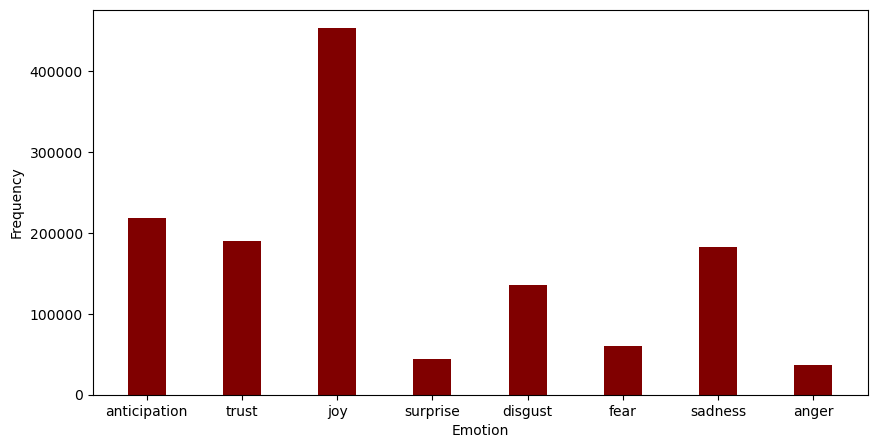

In [44]:
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame.from_dict(emotion_freq, orient='index').reset_index()

emotions = list(emotion_freq.keys())
values = list(emotion_freq.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(emotions, values, color ='maroon',
        width = 0.4)

plt.xlabel("Emotion")
plt.ylabel("Frequency")
plt.show()

In [45]:
result = Counter(" ".join(train_data['text'].values.tolist()).split(" ")).items()
print("Number of unique words before:", len(result))

result = Counter(" ".join(train_data['cleantext'].values.tolist()).split(" ")).items()
print("Number of unique words after:", len(result))

Number of unique words before: 1554172
Number of unique words after: 528907


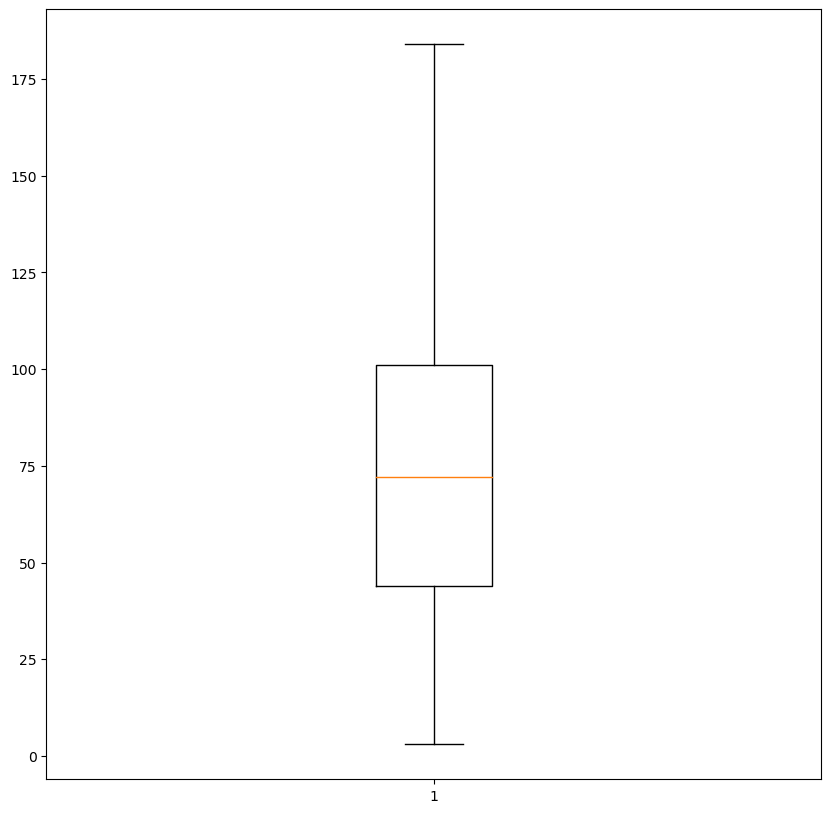

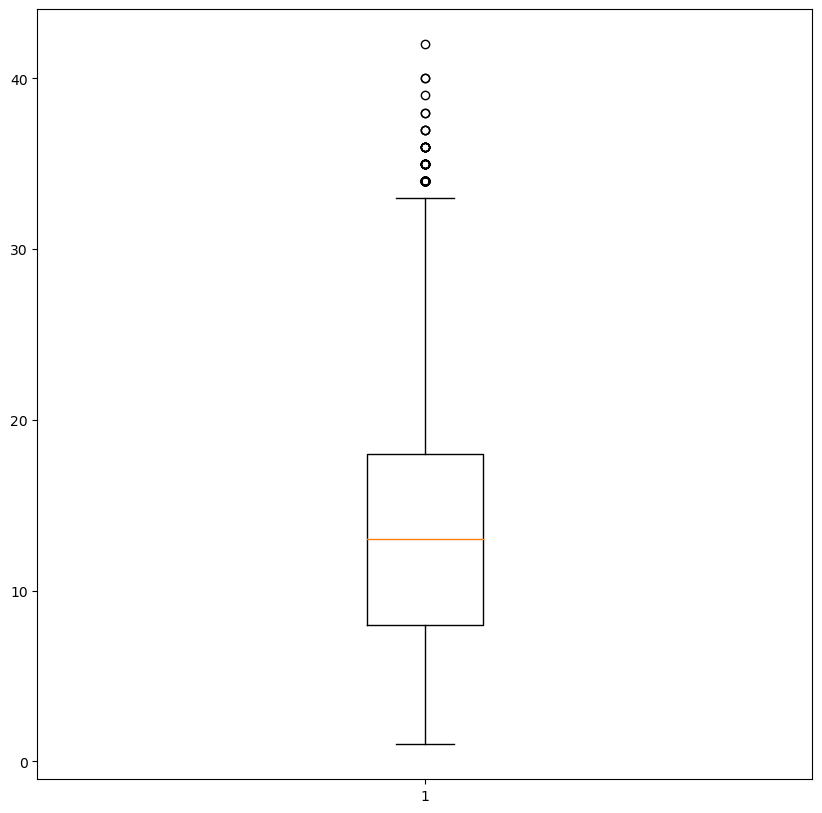

In [46]:
from matplotlib import pyplot as plt

plt.subplots(figsize=(10, 10))
plt.boxplot(train_data.processed_text_length)
plt.show()

plt.subplots(figsize=(10, 10))
plt.boxplot(train_data.processed_word_length)
plt.show()

In [47]:
train_data = train_data.drop(train_data[(train_data.processed_word_length > 70)].index)
train_data = train_data.drop(
    train_data[(train_data.processed_word_length < 3)
               & (train_data.processed_text_length > 50)].index)

In [48]:
train_data.to_pickle("cleaned_train_data.pkl")

# Model selection
I tried to build models as follows:
1. Naive bayes classifier
2. SGD Classifier
3. XGboost Classifier
4. Fasttext Classifier
5. Neural Network - RNN model
6. Transformer BERT

But all of these didn't give a decent prediction. Especially, transformer BERT, I struggle to build this model but it took a lot of time and memories.
So I decided to should `LogisticRegression` to be the model that I will use as a base model.

Interestingly, the model learns better without any preprocessing (Why this can even possible?!!).
I suppose that, all the abbreviation that used in Twitter like slangs or emojis. They become "a language" in the twitter.
When we try to preprocess them, it somehow denatualizes the language in Twitter. I think if we don't have this large dataset like 100k or 200k, preprocessing might matter.
But this dataset consists of more than a million tweets, those noises become prominent "pattern" for model to learn.

So let's see how different they are.

### Logistic regression - Uncleaned data

In [49]:
import pandas as pd
train_uncleaned_data = pd.read_pickle("uncleaned_train_data.pkl")
test_uncleaned_data = pd.read_pickle("uncleaned_test_data.pkl")

In [50]:
from sklearn.model_selection import train_test_split
X = train_uncleaned_data.text
y = train_uncleaned_data.emotion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.07, random_state = 42)

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

logreg = Pipeline([('vect', TfidfVectorizer()),
                   ('clf', LogisticRegression(verbose=1,
                    n_jobs=8, C=1, max_iter=100)),
                   ])

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =      6030192     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.81488D+06    |proj g|=  3.10793D+05


 This problem is unconstrained.



At iterate   50    f=  1.83730D+06    |proj g|=  1.08318D+04

At iterate  100    f=  1.73948D+06    |proj g|=  1.91415D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    100    108      1     0     0   1.914D+04   1.739D+06
  F =   1739480.6152362328     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/kneskung/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:  1.5min finished


In [52]:
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
allemo = ['joy','sadness','trust','anticipation','disgust','surprise','anger','fear']

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=allemo))

accuracy 0.5380213956227304
              precision    recall  f1-score   support

         joy       0.62      0.19      0.29      2749
     sadness       0.62      0.50      0.56     17404
       trust       0.51      0.34      0.41      9717
anticipation       0.69      0.32      0.44      4449
     disgust       0.51      0.84      0.63     36015
    surprise       0.52      0.44      0.48     13533
       anger       0.61      0.18      0.28      3472
        fear       0.58      0.28      0.37     14551

    accuracy                           0.54    101890
   macro avg       0.58      0.39      0.43    101890
weighted avg       0.56      0.54      0.51    101890



### Logistic regression - Cleaned data

In [53]:
import pandas as pd
train_cleaned_data = pd.read_pickle("cleaned_train_data.pkl")
test_cleaned_data = pd.read_pickle("cleaned_test_data.pkl")

In [54]:
from sklearn.model_selection import train_test_split
X = train_cleaned_data.text
y = train_cleaned_data.emotion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.07, random_state = 42)

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

logreg = Pipeline([('vect', TfidfVectorizer()),
                   ('clf', LogisticRegression(verbose=1,
                    n_jobs=8, C=1, max_iter=100)),
                   ])

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =      5687616     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54992D+06    |proj g|=  2.67570D+05


 This problem is unconstrained.



At iterate   50    f=  1.73288D+06    |proj g|=  1.65133D+04

At iterate  100    f=  1.63711D+06    |proj g|=  1.22487D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    100    108      1     0     0   1.225D+04   1.637D+06
  F =   1637107.9306474465     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/kneskung/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:  1.3min finished


In [56]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=allemo))


accuracy 0.5170911927539843
              precision    recall  f1-score   support

         joy       0.57      0.16      0.25      2462
     sadness       0.57      0.48      0.52     15297
       trust       0.48      0.36      0.41      9387
anticipation       0.71      0.34      0.46      4285
     disgust       0.50      0.80      0.62     31798
    surprise       0.51      0.43      0.46     12712
       anger       0.47      0.15      0.23      3102
        fear       0.52      0.28      0.36     13256

    accuracy                           0.52     92299
   macro avg       0.54      0.38      0.42     92299
weighted avg       0.52      0.52      0.49     92299



From above experiment, it is showing that the model learns better with uncleaned data.
- Uncleaned data accuracy: `0.5380213956227304`
- Cleaned data accuracy: 0.5170911927539843


So I tuned the model by setting max iteration to 2000.

In [61]:
X = train_uncleaned_data.text
y = train_uncleaned_data.emotion

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)


In [62]:
logreg = Pipeline([('vect', TfidfVectorizer()),
                   ('clf', LogisticRegression(verbose=1,
                    n_jobs=8, C=1, max_iter=2000)),
                   ])

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =      5889216     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72408D+06    |proj g|=  3.00827D+05


 This problem is unconstrained.



At iterate   50    f=  1.77692D+06    |proj g|=  1.79582D+04

At iterate  100    f=  1.67173D+06    |proj g|=  6.91302D+03

At iterate  150    f=  1.62358D+06    |proj g|=  7.44461D+03

At iterate  200    f=  1.58576D+06    |proj g|=  4.34179D+03

At iterate  250    f=  1.55539D+06    |proj g|=  3.26001D+03

At iterate  300    f=  1.53533D+06    |proj g|=  1.84726D+03

At iterate  350    f=  1.52592D+06    |proj g|=  1.40671D+03

At iterate  400    f=  1.51771D+06    |proj g|=  1.64808D+03

At iterate  450    f=  1.51354D+06    |proj g|=  1.09366D+03

At iterate  500    f=  1.51089D+06    |proj g|=  6.55014D+02

At iterate  550    f=  1.50856D+06    |proj g|=  3.39657D+02

At iterate  600    f=  1.50763D+06    |proj g|=  7.52620D+02

At iterate  650    f=  1.50701D+06    |proj g|=  1.20220D+03

At iterate  700    f=  1.50667D+06    |proj g|=  1.24711D+02

At iterate  750    f=  1.50650D+06    |proj g|=  2.50284D+02

At iterate  800    f=  1.50625D+06    |proj g|=  1.92369D+02

At iter

[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed: 18.1min finished


In [64]:

allemo = ['joy', 'sadness', 'trust', 'anticipation',
          'disgust', 'surprise', 'anger', 'fear']

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=allemo))

prediction = logreg.predict(test_data['text'])
test_data['emotion'] = prediction
test_data[['id', 'emotion']].to_csv(
    'LR.csv', sep=',', encoding='utf-8', index=False)


accuracy 0.5683134442177291
              precision    recall  f1-score   support

         joy       0.61      0.24      0.34      3918
     sadness       0.63      0.57      0.60     25014
       trust       0.51      0.42      0.46     13885
anticipation       0.69      0.38      0.49      6357
     disgust       0.56      0.81      0.66     51439
    surprise       0.53      0.49      0.51     19437
       anger       0.64      0.23      0.33      4947
        fear       0.58      0.35      0.43     20560

    accuracy                           0.57    145557
   macro avg       0.59      0.43      0.48    145557
weighted avg       0.57      0.57      0.55    145557

